# Aura - Natural Language Photo Editing Tool
## Features: Background Removal, Enhancement, Makeup, Reshaping, Skin Smoothing

This notebook integrates all photo editing features with natural language control:
- **Natural Language Interface** - describe edits in plain English
- **GPT-4.1 nano parsing** - converts requests to parameters
- **Precomputed landmarks** - detected once and reused
- **Manual parameter tuning** - full control when needed
- **Modular pipeline** - select features flexibly

## 1. Setup and Imports

In [1]:
import sys
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import Optional, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# Import all feature modules
sys.path.append('/mnt/project')

from background_removal import load_model as load_bg_model, process_image as process_bg
from virtual_makeup import VirtualMakeup, MakeupConfig, PRESET_MAKEUPS
from face_reshape import OpticalFlowReshaper, ReshapeConfig, PRESET_CONFIGS as RESHAPE_PRESETS
from skin_smoothing import SkinSmoothingFilter, BeautyConfig, PRESET_CONFIGS as BEAUTY_PRESETS
from image_enhancement import superres_demo, hue_enhance_lch_v3, gray_world_wb
from color_grading import ColorGradingFilters, ColorGradingConfig, PRESET_FILTERS
from NLP_interface import NaturalLanguageInterface
from blend_background import apply_background_replacement, load_image as load_bg_img

print("All modules imported successfully")

All modules imported successfully


## 2. Load Models (One-time initialization)

In [2]:
## Load Models
print("Loading background removal model...")
bg_model = load_bg_model("/Users/Zheng/Desktop/CIS5810Project/u2netp.pth")
print("Background removal model loaded\n")

print("Loading face landmark detector...")
try:
    import face_alignment
    fa = face_alignment.FaceAlignment(
        face_alignment.LandmarksType.TWO_D,
        device='cpu',
        flip_input=False
    )
    print("Face landmark detector loaded\n")
except ImportError:
    print("face_alignment not installed. Install with: pip install face-alignment")
    fa = None

makeup_processor = VirtualMakeup(device='cpu')
reshape_processor = OpticalFlowReshaper(device='cpu')
beauty_processor = SkinSmoothingFilter(device='cpu')
color_grading_processor = ColorGradingFilters()
print("All processors initialized")

Loading background removal model...
Loading U²-Net P model...
Background removal model loaded

Loading face landmark detector...
Face landmark detector loaded

Loading FAN landmark detector on cpu...
FAN loaded successfully
Loading FAN landmark detector on cpu...
FAN loaded successfully
Loading FAN landmark detector on cpu...
FAN loaded successfully
Color grading filters initialized
All processors initialized


## 3. Helper Functions

In [3]:
def get_landmarks_cached(image_bgr, fa_model):
    """Extract landmarks once and cache for reuse"""
    if fa_model is None:
        print("Face landmark detector not available")
        return None
    
    try:
        rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        landmarks_list = fa_model.get_landmarks(rgb)
        
        if landmarks_list is None or len(landmarks_list) == 0:
            print("No face detected in image")
            return None
        
        landmarks = landmarks_list[0][:, :2]
        print(f"Detected {len(landmarks)} facial landmarks")
        return landmarks
    except Exception as e:
        print(f"Error extracting landmarks: {e}")
        return None

def display_image(img, title="Image", figsize=(8, 8)):
    """Display image"""
    plt.figure(figsize=figsize)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        if img.shape[2] == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

def compare_images(before, after, titles=["Before", "After"], figsize=(14, 7)):
    """Display before/after comparison"""
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    if len(before.shape) == 2:
        plt.imshow(before, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    plt.title(titles[0])
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    if len(after.shape) == 2:
        plt.imshow(after, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    plt.title(titles[1])
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Helper functions defined")

Helper functions defined


## 4. Configuration: Choose Input Mode

In [ ]:
# === USER INPUT: Choose how to configure the pipeline ===

# Option 1: Natural Language Mode (recommended)
USE_NATURAL_LANGUAGE = True
OPENAI_API_KEY = "API_KEY"  # Replace with your OpenAI API key
USER_REQUEST = "add high contrast filter"

# Option 2: Manual Parameter Mode
USE_MANUAL_PARAMS = False

# Image settings
INPUT_IMAGE_PATH = "/Users/zheng/Desktop/CIS5810Project/Shi-2631-1.jpg"
OUTPUT_DIR = "/Users/zheng/Desktop/CIS5810Project/aura_output"

print(f"Mode: {'Natural Language' if USE_NATURAL_LANGUAGE else 'Manual Parameters'}")
if USE_NATURAL_LANGUAGE:
    print(f'Request: "{USER_REQUEST}"')
    
# Background replacement (optional)
USE_BACKGROUND_REPLACEMENT = False
BACKGROUND_IMAGE_PATH = "/Users/Zheng/Downloads/new_background.webp"

Mode: Natural Language
Request: "add high contrast filter"


## 5. Load Input Image and Parse Request (if needed)


Loading image from: /Users/zheng/Desktop/CIS5810Project/Shi-2631-1.jpg
Image loaded: (1632, 1434, 3)


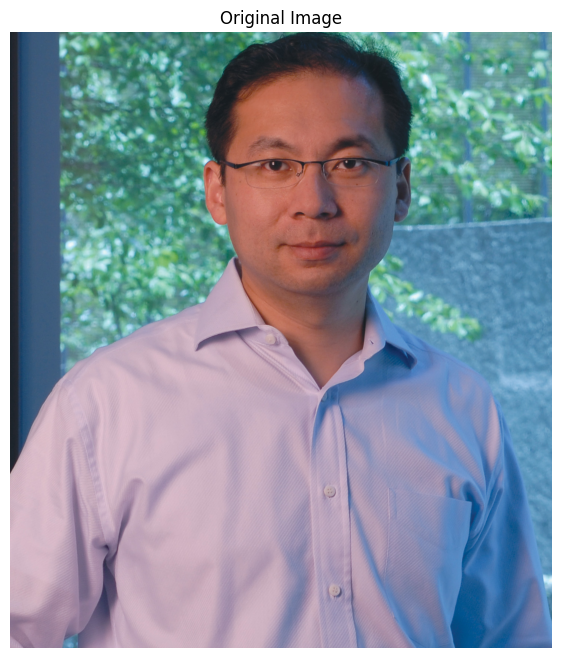


PARSING NATURAL LANGUAGE REQUEST

User: "add high contrast filter"

PARSED EDITING PARAMETERS

Features to apply: 1
  ✓ Color grading

Color Grading:
  Filter: high_contrast
  Intensity: 0.80



In [5]:
# Load image
print(f"\nLoading image from: {INPUT_IMAGE_PATH}")
original_image = cv2.imread(INPUT_IMAGE_PATH)

if original_image is None:
    raise ValueError(f"Could not load image from {INPUT_IMAGE_PATH}")

print(f"Image loaded: {original_image.shape}")
display_image(original_image, "Original Image")

# Parse request or use manual params
if USE_NATURAL_LANGUAGE:
    print("\n" + "="*60)
    print("PARSING NATURAL LANGUAGE REQUEST")
    print("="*60)
    
    nlp = NaturalLanguageInterface(OPENAI_API_KEY)
    print(f'\nUser: "{USER_REQUEST}"')
    
    parsed_params = nlp.parse_request(USER_REQUEST)
    parsed_params = nlp.validate_and_normalize(parsed_params)
    nlp.print_summary(parsed_params)
    
    SELECTED_FEATURES = parsed_params["features"]
    ENHANCEMENT_PARAMS = parsed_params.get("enhancement_params", {})
    makeup_config_dict = parsed_params.get("makeup_config", {})
    reshape_config_dict = parsed_params.get("reshape_config", {})
    beauty_config_dict = parsed_params.get("beauty_config", {})
    color_grading_config_dict = parsed_params.get("color_grading_config", {})
    background_config_dict = parsed_params.get("background_config", {})
    
elif USE_MANUAL_PARAMS:
    SELECTED_FEATURES = {
        'enhancement': False,
        'makeup': True,
        'reshape': True,
        'smoothing': True,
        'color_grading': True,
        'background_replacement': False
    }
    
    ENHANCEMENT_PARAMS = {}
    makeup_config_dict = {'preset': 'natural'}
    reshape_config_dict = {'preset': 'subtle'}
    beauty_config_dict = {'preset': 'strong'}
    color_grading_config_dict = {'filter_name': 'cinematic', 'intensity': 0.8}
    background_config_dict = {}
    
    print("\nManual parameters configured")

## 6. Background Processing (Automatic)
This runs automatically when you load an image:
- **Background removal** - create transparent PNG
- **Landmark detection** - cache for later features


BACKGROUND PROCESSING

[1/2] Removing background...
Saved transparent output to: /Users/zheng/Desktop/CIS5810Project/aura_output/0_background_removed.png
Background removed: /Users/zheng/Desktop/CIS5810Project/aura_output/0_background_removed.png

[2/2] Detecting facial landmarks...


libpng warning: iCCP: known incorrect sRGB profile


Detected 68 facial landmarks

BACKGROUND PROCESSING COMPLETE


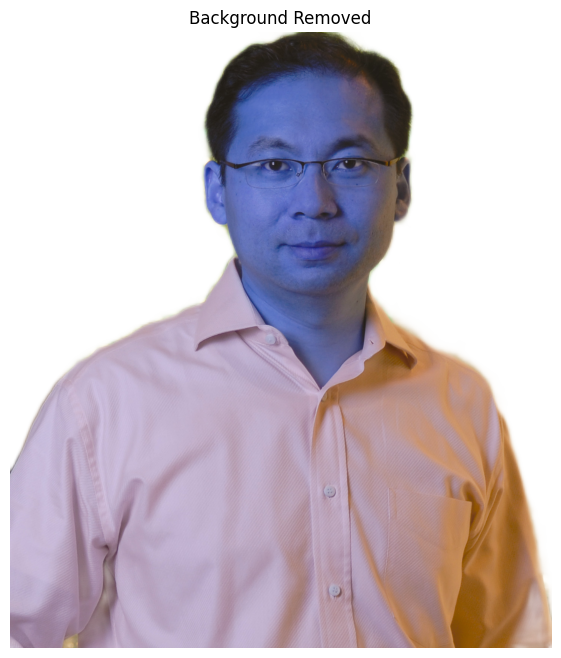

In [6]:
print("\n" + "="*60)
print("BACKGROUND PROCESSING")
print("="*60)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save original
original_path = os.path.join(OUTPUT_DIR, "0_original.jpg")
cv2.imwrite(original_path, original_image)

# Remove background
print("\n[1/2] Removing background...")
bg_removed_path = os.path.join(OUTPUT_DIR, "0_background_removed.png")
process_bg(bg_model, INPUT_IMAGE_PATH, bg_removed_path)
bg_removed = cv2.imread(bg_removed_path, cv2.IMREAD_UNCHANGED)
print(f"Background removed: {bg_removed_path}")

if bg_removed.shape[2] == 4:
    # Foreground (BGR)
    foreground = bg_removed[:, :, :3]

    # Alpha mask (0–255 → 0–1)
    alpha = bg_removed[:, :, 3] / 255.0
else:
    raise ValueError("Background removal did not produce an alpha channel")

# Detect landmarks
print("\n[2/2] Detecting facial landmarks...")
cached_landmarks = get_landmarks_cached(original_image, fa)

print("\n" + "="*60)
print("BACKGROUND PROCESSING COMPLETE")
print("="*60)

if bg_removed is not None:
    display_image(bg_removed, "Background Removed")

## 7. Apply Features (Processing Pipeline)

In [7]:
## Processing Pipeline
print("\n" + "="*60)
print("PROCESSING PIPELINE")
print("="*60)

# Background Replacement
if SELECTED_FEATURES.get('background_replacement', False) or USE_BACKGROUND_REPLACEMENT:
    print("\nApplying background replacement...")
    
    bg_path = background_config_dict.get('background_path') or BACKGROUND_IMAGE_PATH
    if bg_path and os.path.exists(bg_path):
        bg_img = load_bg_img(bg_path)
        
        replaced = apply_background_replacement(
            foreground_img=foreground,
            background_img=bg_img,
            foreground_mask=alpha
        )
        
        current_image = replaced
        
        bg_replaced_path = os.path.join(OUTPUT_DIR, "0_background_replaced.jpg")
        cv2.imwrite(bg_replaced_path, replaced)
        
        print(f"Background replaced: saved to {bg_replaced_path}")
        display_image(replaced, "Background Replaced Result")
    else:
        print(f"Background image not found, skipping")
        current_image = original_image.copy()
else:
    current_image = original_image.copy()

results = {}
feature_count = sum(SELECTED_FEATURES.values())
current_step = 0


PROCESSING PIPELINE


### 7.1 Face Reshaping

In [8]:
if SELECTED_FEATURES.get('reshape', False):
    current_step += 1
    print(f"\n[{current_step}/{feature_count}] FACE RESHAPING")
    print("-" * 60)
    
    if cached_landmarks is not None:
        # Get config
        if reshape_config_dict.get("preset"):
            reshape_config = RESHAPE_PRESETS[reshape_config_dict["preset"]]
        else:
            reshape_config = ReshapeConfig(
                slim_factor=reshape_config_dict.get("slim_factor", 0.0),
                eye_factor=reshape_config_dict.get("eye_factor", 0.0),
                chin_factor=reshape_config_dict.get("chin_factor", 0.0),
                nose_factor=reshape_config_dict.get("nose_factor", 0.0)
            )
        
        try:
            landmarks = cached_landmarks
            
            print("  Computing target shape...")
            target_landmarks = reshape_processor.compute_target_landmarks(landmarks, reshape_config)
            
            print("  Computing optical flow...")
            map_x, map_y = reshape_processor.compute_optical_flow(landmarks, target_landmarks, current_image.shape)
            
            print("  Warping image...")
            warped = reshape_processor.apply_optical_flow(current_image, map_x, map_y)
            
            print("  Blending...")
            mask = reshape_processor.create_blend_mask(landmarks, current_image.shape)
            mask_norm = mask.astype(np.float32) / 255.0
            
            blended = current_image.copy().astype(np.float32)
            for c in range(3):
                blended[:, :, c] = (mask_norm * warped[:, :, c].astype(np.float32) + 
                                  (1 - mask_norm) * current_image[:, :, c].astype(np.float32))
            
            current_image = blended.astype(np.uint8)
            
            step_path = os.path.join(OUTPUT_DIR, f"{current_step}_reshape.jpg")
            cv2.imwrite(step_path, current_image)
            results['reshape'] = current_image.copy()
            
            print("  Complete")
            compare_images(original_image, current_image, ["Original", "After Reshaping"])
            
        except Exception as e:
            print(f"  Failed: {e}")
    else:
        print("  Skipping (no landmarks)")

### 7.2 Skin Smoothing

In [9]:
if SELECTED_FEATURES.get('smoothing', False):
    current_step += 1
    print(f"\n[{current_step}/{feature_count}] SKIN SMOOTHING")
    print("-" * 60)
    
    # Get config
    if beauty_config_dict.get("preset"):
        beauty_config = BEAUTY_PRESETS[beauty_config_dict["preset"]]
    else:
        beauty_config = BeautyConfig(
            smooth_strength=beauty_config_dict.get("smooth_strength", 0.6),
            brightness_boost=beauty_config_dict.get("brightness_boost", 1.05),
            contrast_adjustment=beauty_config_dict.get("contrast_adjustment", 1.02),
            sharpen_amount=beauty_config_dict.get("sharpen_amount", 0.3),
            skin_tone_balance=beauty_config_dict.get("skin_tone_balance", 0.15),
            blemish_removal=beauty_config_dict.get("blemish_removal", True)
        )
    
    try:
        print("  Creating skin mask...")
        skin_mask = beauty_processor.create_skin_mask(current_image, cached_landmarks)
        
        result = current_image.copy()
        
        if beauty_config.blemish_removal:
            print("  Removing blemishes...")
            result = beauty_processor.remove_blemishes(result, skin_mask)
        
        print("  Smoothing...")
        smoothed = beauty_processor.edge_preserving_smooth(result, beauty_config.smooth_strength)
        
        print("  Applying guided filter...")
        for _ in range(3):
            smoothed = beauty_processor.guided_filter(smoothed, result, radius=12, eps=0.02)
        
        print("  Blending...")
        mask_norm = skin_mask.astype(np.float32) / 255.0
        for c in range(3):
            result[:, :, c] = (mask_norm * smoothed[:, :, c].astype(np.float32) + 
                              (1 - mask_norm) * result[:, :, c].astype(np.float32))
        result = result.astype(np.uint8)
        
        print("  Balancing tone...")
        result = beauty_processor.balance_skin_tone(result, skin_mask, beauty_config.skin_tone_balance)
        
        print("  Adjusting brightness...")
        result = beauty_processor.adjust_brightness_contrast(result, beauty_config.brightness_boost, beauty_config.contrast_adjustment)
        
        print("  Sharpening details...")
        result = beauty_processor.sharpen_details(result, beauty_config.sharpen_amount, skin_mask)
        
        current_image = result
        
        step_path = os.path.join(OUTPUT_DIR, f"{current_step}_smoothing.jpg")
        cv2.imwrite(step_path, current_image)
        results['smoothing'] = current_image.copy()
        
        print("  Complete")
        compare_images(results.get('reshape', original_image), current_image, ["Before", "After Smoothing"])
        
    except Exception as e:
        print(f"  Failed: {e}")

### 7.3 Virtual Makeup

In [10]:
if SELECTED_FEATURES.get('makeup', False):
    current_step += 1
    print(f"\n[{current_step}/{feature_count}] VIRTUAL MAKEUP")
    print("-" * 60)
    
    if cached_landmarks is not None:
        # Get config
        if makeup_config_dict.get("preset"):
            makeup_config = PRESET_MAKEUPS[makeup_config_dict["preset"]]
        else:
            makeup_config = MakeupConfig(
                lipstick_color=tuple(makeup_config_dict.get("lipstick_color", [180, 38, 45])),
                lipstick_intensity=makeup_config_dict.get("lipstick_intensity", 0.0),
                blush_color=tuple(makeup_config_dict.get("blush_color", [255, 150, 150])),
                blush_intensity=makeup_config_dict.get("blush_intensity", 0.0),
                eyeshadow_color=tuple(makeup_config_dict.get("eyeshadow_color", [150, 100, 80])),
                eyeshadow_intensity=makeup_config_dict.get("eyeshadow_intensity", 0.0),
                eyeliner_color=tuple(makeup_config_dict.get("eyeliner_color", [20, 20, 20])),
                eyeliner_thickness=makeup_config_dict.get("eyeliner_thickness", 0),
                eyebrow_color=tuple(makeup_config_dict.get("eyebrow_color", [60, 40, 30])),
                eyebrow_intensity=makeup_config_dict.get("eyebrow_intensity", 0.0)
            )
        
        try:
            result = current_image.copy()
            landmarks = cached_landmarks
            
            if makeup_config.eyeshadow_intensity > 0:
                print("  Applying eyeshadow...")
                result = makeup_processor.apply_eyeshadow(result, landmarks, makeup_config.eyeshadow_color, makeup_config.eyeshadow_intensity)
            
            if makeup_config.eyeliner_thickness > 0:
                print("  Applying eyeliner...")
                result = makeup_processor.apply_eyeliner(result, landmarks, makeup_config.eyeliner_color, makeup_config.eyeliner_thickness)
            
            if makeup_config.eyebrow_intensity > 0:
                print("  Enhancing eyebrows...")
                result = makeup_processor.apply_eyebrow_enhancement(result, landmarks, makeup_config.eyebrow_color, makeup_config.eyebrow_intensity)
            
            if makeup_config.blush_intensity > 0:
                print("  Applying blush...")
                result = makeup_processor.apply_blush(result, landmarks, makeup_config.blush_color, makeup_config.blush_intensity)
            
            if makeup_config.lipstick_intensity > 0:
                print("  Applying lipstick...")
                result = makeup_processor.apply_lipstick(result, landmarks, makeup_config.lipstick_color, makeup_config.lipstick_intensity)
            
            current_image = result
            
            step_path = os.path.join(OUTPUT_DIR, f"{current_step}_makeup.jpg")
            cv2.imwrite(step_path, current_image)
            results['makeup'] = current_image.copy()
            
            print("  Complete")
            compare_images(results.get('smoothing', results.get('reshape', original_image)), current_image, ["Before", "After Makeup"])
            
        except Exception as e:
            print(f"  Failed: {e}")
    else:
        print("  Skipping (no landmarks)")

### 7.4 Color Grading


[1/1] COLOR GRADING
------------------------------------------------------------
  Applying filter: high_contrast
  Intensity: 0.8
  Complete


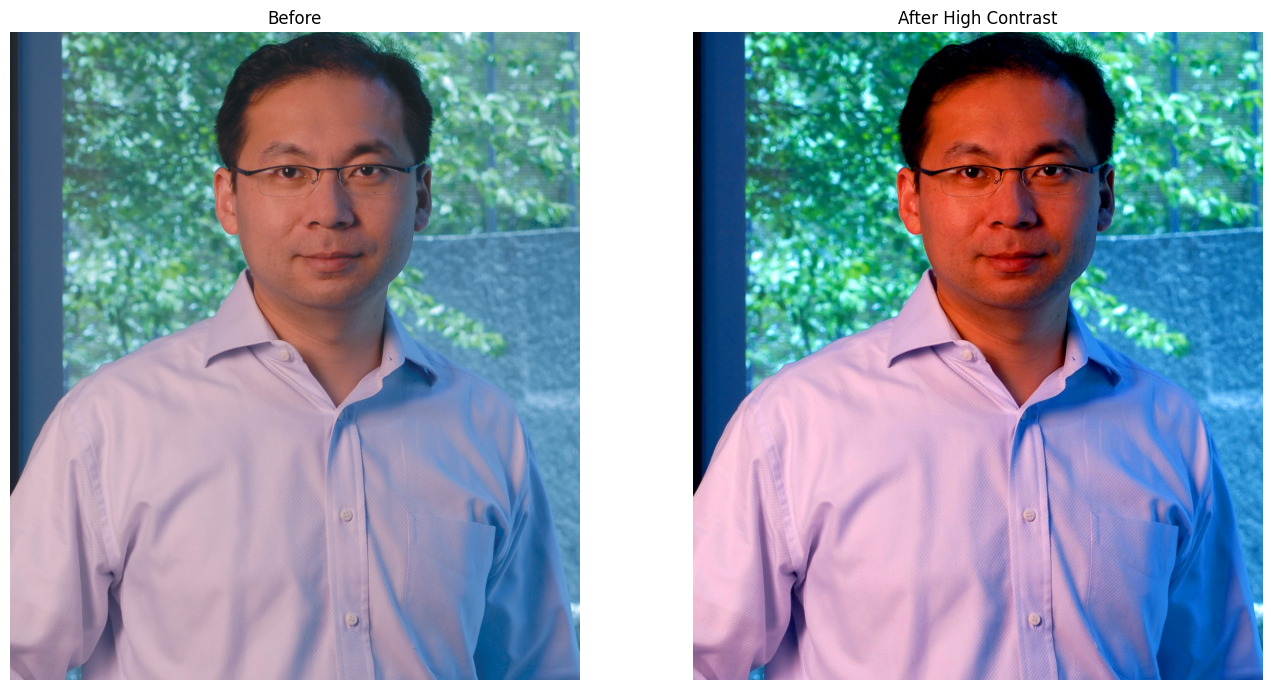

In [11]:
if SELECTED_FEATURES.get('color_grading', False):
    current_step += 1
    print(f"\n[{current_step}/{feature_count}] COLOR GRADING")
    print("-" * 60)
    
    try:
        if color_grading_config_dict.get("filter_name"):
            filter_name = color_grading_config_dict["filter_name"]
            intensity = color_grading_config_dict.get("intensity", 0.8)
            
            print(f"  Applying filter: {filter_name}")
            print(f"  Intensity: {intensity}")
            
            result = color_grading_processor.apply_filter(current_image, filter_name, intensity)
            current_image = result
            
            step_path = os.path.join(OUTPUT_DIR, f"{current_step}_color_grading.jpg")
            cv2.imwrite(step_path, current_image)
            results['color_grading'] = current_image.copy()
            
            print("  Complete")
            compare_images(results.get('makeup', results.get('smoothing', results.get('reshape', original_image))), 
                          current_image, ["Before", f"After {filter_name.replace('_', ' ').title()}"])
        else:
            print("  No filter specified, skipping")
            
    except Exception as e:
        print(f"  Failed: {e}")
        import traceback
        traceback.print_exc()

### 7.5 Enhancement (Super-resolution)

In [12]:
if SELECTED_FEATURES.get('enhancement', False):
    current_step += 1
    print(f"\n[{current_step}/{feature_count}] IMAGE ENHANCEMENT")
    print("-" * 60)
    
    try:
        print("  Upscaling with edge-aware sharpening...")
        hr_rgb = superres_demo(
            current_image,
            scale=ENHANCEMENT_PARAMS.get('scale', 4),
            amount=ENHANCEMENT_PARAMS.get('amount', 0.6),
            base=ENHANCEMENT_PARAMS.get('base', 0.15),
            use_clahe=ENHANCEMENT_PARAMS.get('use_clahe', True)
        )
        
        print("  Enhancing colors...")
        hr_bgr = cv2.cvtColor(hr_rgb, cv2.COLOR_RGB2BGR)
        hr_bgr = hue_enhance_lch_v3(
            hr_bgr,
            chroma_boost=ENHANCEMENT_PARAMS.get('chroma_boost', 1.18)
        )
        
        current_image = hr_bgr
        
        step_path = os.path.join(OUTPUT_DIR, f"{current_step}_enhancement.jpg")
        cv2.imwrite(step_path, current_image)
        results['enhancement'] = current_image.copy()
        
        print("  Complete")
        
    except Exception as e:
        print(f"  Failed: {e}")

## 8. Final Results


FINAL COMPARISON


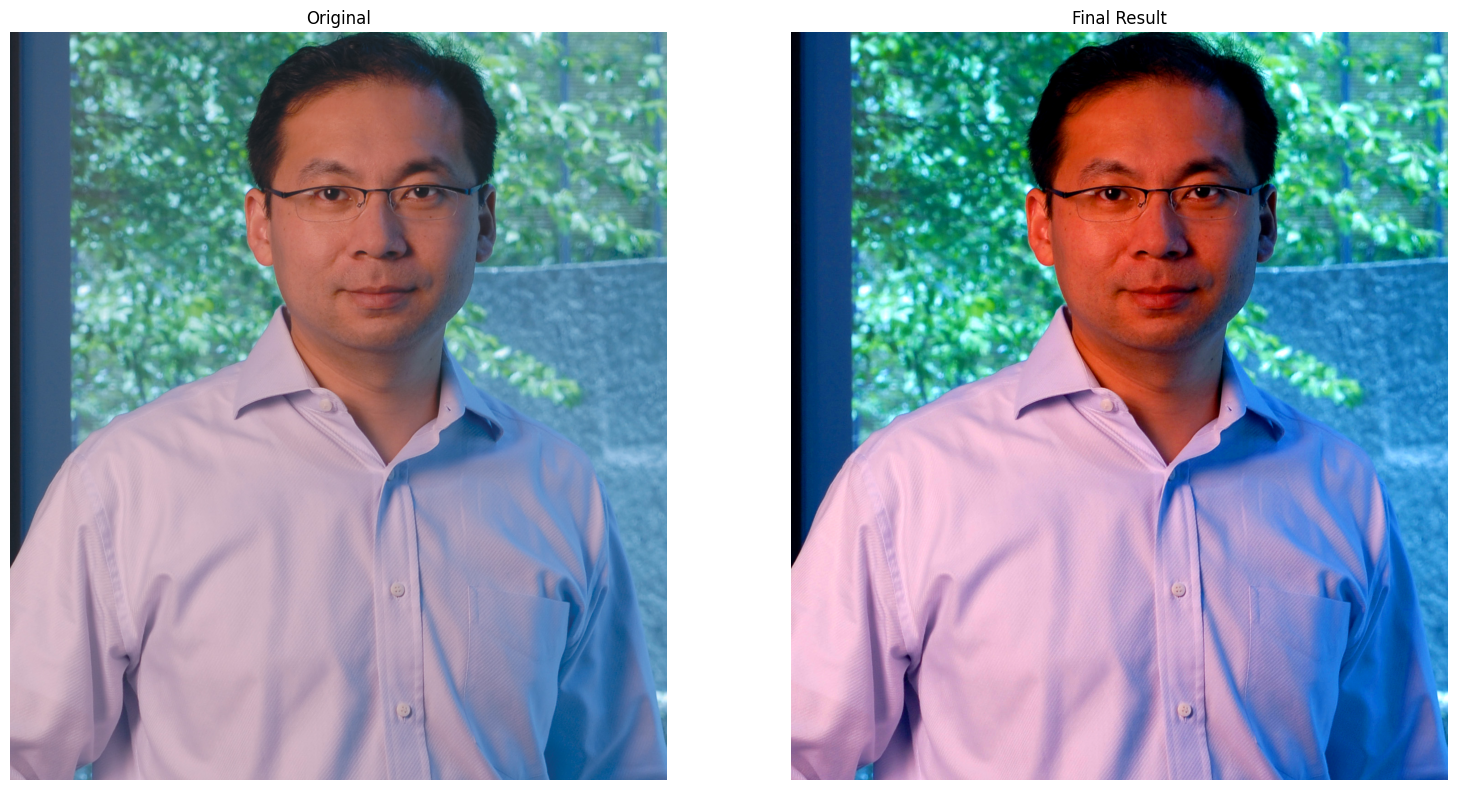


PROCESSING STAGES


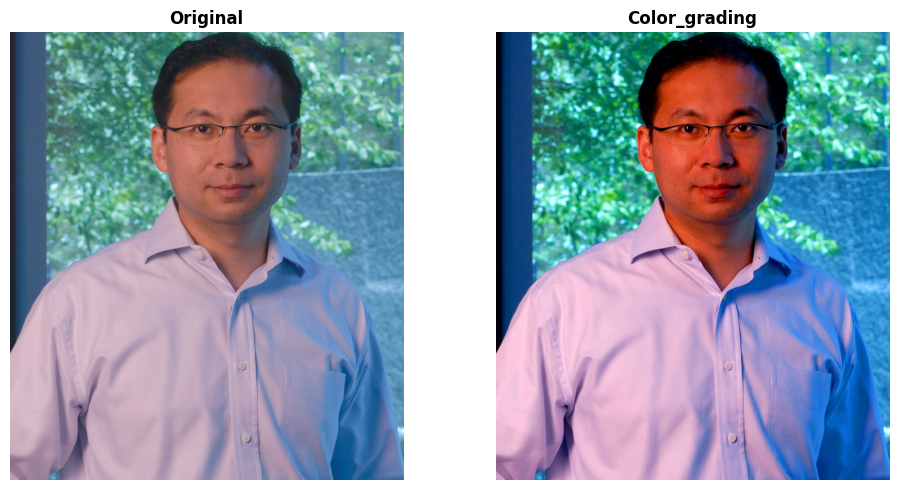

In [13]:
final_path = os.path.join(OUTPUT_DIR, "final_result.jpg")
cv2.imwrite(final_path, current_image)

print("\nFINAL COMPARISON")
print("="*60)

final_result = current_image

if SELECTED_FEATURES.get('enhancement', False) and original_image.shape != final_result.shape:
    h, w = final_result.shape[:2]
    original_resized = cv2.resize(original_image, (w, h), interpolation=cv2.INTER_CUBIC)
    compare_images(original_resized, final_result, 
                  [f"Original ({original_image.shape[1]}x{original_image.shape[0]})", 
                   f"Final ({final_result.shape[1]}x{final_result.shape[0]})"],
                  figsize=(16, 8))
else:
    compare_images(original_image, final_result, ["Original", "Final Result"], figsize=(16, 8))

if len(results) > 0:
    print("\nPROCESSING STAGES")
    n_stages = len(results) + 1
    fig, axes = plt.subplots(1, n_stages, figsize=(5*n_stages, 5))
    
    all_stages = [("Original", original_image)] + [(k.capitalize(), v) for k, v in results.items()]
    
    for idx, (stage_name, stage_img) in enumerate(all_stages):
        ax = axes[idx] if n_stages > 1 else axes
        
        display_img = stage_img
        if stage_img.shape != final_result.shape and SELECTED_FEATURES.get('enhancement', False):
            h, w = final_result.shape[:2]
            display_img = cv2.resize(stage_img, (w, h), interpolation=cv2.INTER_CUBIC)
        
        ax.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        ax.set_title(stage_name, fontsize=12, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## 9. Summary

In [14]:
print("\n" + "="*60)
print("PROCESSING SUMMARY")
print("="*60)

print(f"\nInput: {INPUT_IMAGE_PATH}")
print(f"Original Size: {original_image.shape[1]}x{original_image.shape[0]}")
print(f"Final Size: {final_result.shape[1]}x{final_result.shape[0]}")

if USE_NATURAL_LANGUAGE:
    print(f'\nRequest: "{USER_REQUEST}"')

print(f"\nFeatures Applied: {sum(SELECTED_FEATURES.values())}")
for feature, enabled in SELECTED_FEATURES.items():
    if enabled:
        print(f"  {feature.replace('_', ' ').capitalize()}")

print(f"\nLandmarks: {'Yes' if cached_landmarks is not None else 'No'}")

print(f"\nOutput Directory: {OUTPUT_DIR}")
print("Files saved:")
print(f"  • 0_original.jpg")
print(f"  • 0_background_removed.png")
if SELECTED_FEATURES.get('background_replacement', False):
    print(f"  • 0_background_replaced.jpg")
for i, (name, _) in enumerate(results.items(), 1):
    print(f"  • {i}_{name}.jpg")
print(f"  • final_result.jpg")

print("\n" + "="*60)
print("COMPLETE")
print("="*60)


PROCESSING SUMMARY

Input: /Users/zheng/Desktop/CIS5810Project/Shi-2631-1.jpg
Original Size: 1434x1632
Final Size: 1434x1632

Request: "add high contrast filter"

Features Applied: 1
  Color grading

Landmarks: Yes

Output Directory: /Users/zheng/Desktop/CIS5810Project/aura_output
Files saved:
  • 0_original.jpg
  • 0_background_removed.png
  • 1_color_grading.jpg
  • final_result.jpg

COMPLETE


## Usage Examples

### Natural Language Examples:
```python
# Example 1: Simple editing
USER_REQUEST = "slim my face a little, smooth my face hard, add pink lipstick"

# Example 2: Glamorous look
USER_REQUEST = "make me look glamorous with bold red lips"

# Example 3: Natural enhancement
USER_REQUEST = "enlarge my eyes slightly and smooth skin naturally"

# Example 4: Full enhancement
USER_REQUEST = "enhance image quality and add natural makeup"

# Example 5: Specific adjustments
USER_REQUEST = "refine my chin moderately, remove blemishes, and add nude lipstick"
```

### Intensity Keywords:
- **Subtle**: "a little", "slight", "subtle" → 0.1-0.3
- **Moderate**: "moderately", "some" → 0.4-0.6
- **Strong**: "hard", "strong", "very" → 0.7-0.9
- **Intense**: "extremely", "maximum" → 0.9-1.0

### Lipstick Colors:
- Pink: RGB(255,150,170)
- Red: RGB(180,38,45)
- Bold Red: RGB(160,20,30)
- Nude: RGB(220,120,130)
- Berry: RGB(150,50,80)